Пока в работе

####1. Попробуйте изменить параметры нейронной сети, либо нейронной сети, работающей airline-passengers (она прилагается вместе с датасетом к уроку в виде отдельного скрипта) или любым любимым временным рядом так, чтобы улучшить её точность. Приложите анализ

In [ ]:
# Рисовать графики сразу же
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import utils
import numpy as np
import tensorflow.keras as keras

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM

from google.colab import files
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import os
import datetime

In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

In [ ]:
files.upload()
!ls

Saving PJME_Потребление_энергии_D.csv to PJME_Потребление_энергии_D (18).csv
 logs2				       'PJME_Потребление_энергии_D (2).csv'
'PJME_Потребление_энергии_D (10).csv'  'PJME_Потребление_энергии_D (3).csv'
'PJME_Потребление_энергии_D (11).csv'  'PJME_Потребление_энергии_D (4).csv'
'PJME_Потребление_энергии_D (12).csv'  'PJME_Потребление_энергии_D (5).csv'
'PJME_Потребление_энергии_D (13).csv'  'PJME_Потребление_энергии_D (6).csv'
'PJME_Потребление_энергии_D (14).csv'  'PJME_Потребление_энергии_D (7).csv'
'PJME_Потребление_энергии_D (15).csv'  'PJME_Потребление_энергии_D (8).csv'
'PJME_Потребление_энергии_D (16).csv'  'PJME_Потребление_энергии_D (9).csv'
'PJME_Потребление_энергии_D (17).csv'   PJME_Потребление_энергии_D.csv
'PJME_Потребление_энергии_D (18).csv'   sample_data
'PJME_Потребление_энергии_D (1).csv'


In [ ]:
#df = pd.read_csv('my_BRENT2019.csv')
df = pd.read_csv('/content/PJME_Потребление_энергии_D.csv')
df.index = df.Date
df.drop(['Date'],axis=1,inplace = True)

In [ ]:
df.head()

,PJME_MW
Date,
2002-01-01,714857.0
2002-01-02,822277.0
2002-01-03,828285.0
2002-01-04,809171.0
2002-01-05,729723.0


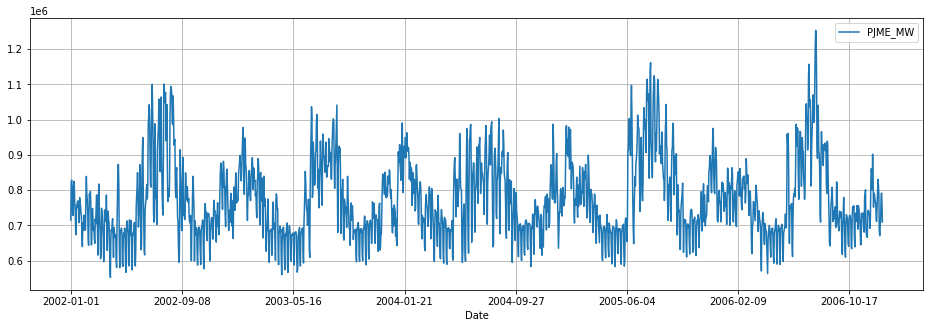

In [ ]:
df.plot( figsize = (16,5))
#df['PJME_MW'].plot( figsize = (16,5))

plt.grid('On')
plt.show()

In [ ]:
df.describe()

,PJME_MW
count,1.825000e+03
mean,7.738672e+05
std,1.115791e+05
min,5.519940e+05
25%,6.948500e+05
50%,7.531920e+05
75%,8.391540e+05
max,1.253516e+06


In [ ]:
#data = df.iloc[1500:,1:]  # BRENT убираем данные до 2015 года , т.к. сильно изменилось поведение и дату-время, т.к. она дублирована другими признаками
data = df.copy() # берем все что есть

In [ ]:
data.shape[1]

1

####**Ответ**: Добавим номер месяца и номер дня в неделе

Рез-ты при том же кол-ве эпох ухудшились, если поднять кол-во эпох до 30 рез-ты практически те же val_mae в районе 0.3112 лаговые корреляции так же практически те же.

Попробую оставить только месяц
рез-ты по val_mae прктически те же, при увеличении кол-ва эпох в конце может наблюдатся резкое увеличение val_mae


В итоге оставлю и номер дня в неделе и месяц, т.к. при тестировании на 50 эпохах добился val_mae: 0.28

In [ ]:
date_list = pd.to_datetime(data.index, format='%Y-%m-%d')

In [ ]:
data['month'] = date_list.month
data['weekday'] = date_list.weekday

In [ ]:
data.head(5)

,PJME_MW,month,weekday
Date,,,
2002-01-01,714857.0,1,1
2002-01-02,822277.0,1,2
2002-01-03,828285.0,1,3
2002-01-04,809171.0,1,4
2002-01-05,729723.0,1,5


Делаем нормализацию

In [ ]:
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

####**Ответ**, попробую убрать нормализацию
Как итог рез-ты первичной модели ухудшились, после 14-15 эпохи наблюдается рост val_mae.
Рез-ты вторичной модели показали рез-т  val_mae: 0.28

Можно (и нужно заменять на sklearn StandadScaler) т.к. это нужно дополнительно сохранять для обработки реальных данных , но тут сделаем без привлечения внешних модулей

In [ ]:
train_split = 1000
data_v =  normalize(data.values, train_split)
data_f = pd.DataFrame(data_v)

Создаем данные для обучения

In [ ]:
# список признаков, по которым будем учить
#channelIndexes = [0, 1, 2, 3] # BRENT
# channelIndexes = [0]
channelIndexes = [0, 1, 2]

# длина теста
valLen = 100
# длина истории для работы
xLen = 30
# отступ тестов от тренировок
bias = 10

# вычисляем точку разделения ряда на тесты и тренировку
#train_split = data_f.shape[0] - valLen - bias
# делим
train_data = data_f.iloc[0: train_split, channelIndexes]
val_data = data_f.iloc[train_split+bias:, channelIndexes]

####**Ответ** попробую изменить длину истории
Опыт показал отрицательный рез-т

In [ ]:
train_data.head(7)

,0,1,2
0,-0.493448,-1.542765,-1.002128
1,0.508508,-1.542765,-0.501814
2,0.564548,-1.542765,-0.001501
3,0.386262,-1.542765,0.498812
4,-0.354786,-1.542765,0.999126
5,-0.373040,-1.542765,1.499439
6,0.300832,-1.542765,-1.502441


Формируем параметры для генерации выборки

In [ ]:
# шаг по данным для построения обучающих примеров
step = 1

# длина прошлого 
past = xLen
p = past
# горизонт предсказания
future = 1
h=future

# параметры модели для обучения
learning_rate = 0.001
batch_size = 32
epochs = 20

####**Ответ** пробую увеличить кол-во эпох до 50
Рез-ты, на тех же остальных настройках и первичном датасете, на 19ой эпохе улучшились до val_mae в районе 0.2990, дальше 19ой эпохи смысла обучать нет.

Лекция 01:33

In [ ]:
Chanel_numb = len(channelIndexes)

start = xLen + future
end = start + train_split-1

xTrain_df = train_data.iloc[:-future-xLen+1,:] # сдвиг по времени для предсказания (закончить чуть раньше)
xTrain = xTrain_df[[train_data.columns[i] for i in range(Chanel_numb)]].values
yTrain = train_data.iloc[future+xLen-1:,0].values  # сдвиг по времени для предсказания (начать чуть позднее)

sequence_length = int(xLen / step)

x_end = len(val_data) - xLen - future 

label_start = len(train_data)+bias+xLen + future +1

xVal_df = val_data.iloc[:-future-xLen+1,:] # сдвиг по времени для предсказания (закончить чуть раньше)
xVal = xVal_df[[val_data.columns[i] for i in range(Chanel_numb)]].values
yVal = val_data.iloc[future+xLen-1:,0].values  # сдвиг по времени для предсказания (начать чуть позднее)

In [ ]:
print(xTrain.shape)
print(yTrain.shape)
print(xVal.shape)
print(yVal.shape)

(970, 3)
(970,)
(785, 3)
(785,)


Посмотрим на них

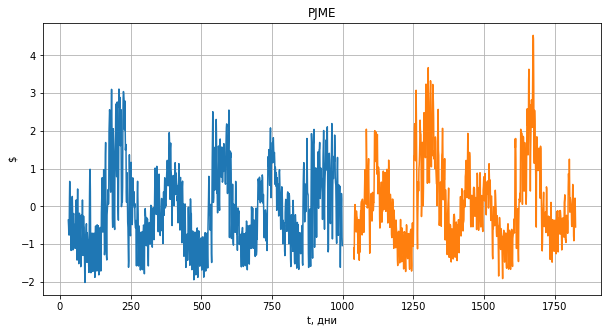

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(data_f.index[xLen:yTrain.shape[0]+xLen],yTrain[:])
plt.plot(data_f.index[yTrain.shape[0]+bias+future+2*xLen-1:],yVal[:])
plt.grid('on')
plt.xlabel('t, дни')
plt.ylabel('$')
#plt.title('стоимость BRENT в 2010-2018')
plt.title('PJME')
plt.show()

In [ ]:
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    xTrain,
    yTrain,
    sequence_length=xLen,
    sampling_rate=1,
    batch_size=batch_size,
)
dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    xVal,
    yVal,
    sequence_length=xLen,
    sampling_rate=1,
    batch_size=batch_size,
)

In [ ]:
for batch in dataset_val.take(2):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (32, 30, 3)
Target shape: (32,)


In [ ]:
inputs[0,:,0]

<tf.Tensor: shape=(30,), dtype=float64, numpy=
array([-0.5342466 , -0.08216298,  0.0500725 , -0.32521809, -0.16344252,
       -0.6244805 , -0.67745118, -0.11983661, -0.25586838, -0.2949318 ,
       -0.46182815, -0.57100614, -1.03337795, -1.24374962, -0.43178438,
       -0.34715629, -0.40026688, -1.42454389, -0.76285346, -0.94350782,
       -1.20751241, -0.28299265, -0.11243993, -0.14171885,  0.06493116,
        0.13566133, -0.32106736, -0.75496242,  0.19243762,  0.1295705 ])>

In [ ]:
targets[0]

<tf.Tensor: shape=(), dtype=float64, numpy=-0.2769764325830288>

Лекция 01:41

In [ ]:
logdir = os.path.join("logs2", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard( logdir, histogram_freq=1)

**сеть: LSTM слои+Conv1D +Dense слой.**

Epoch 1/20
30/30 [==============================] - 5s 76ms/step - loss: 0.8109 - mae: 0.7067 - val_loss: 0.9571 - val_mae: 0.7394
Epoch 2/20
30/30 [==============================] - 1s 41ms/step - loss: 0.6597 - mae: 0.6382 - val_loss: 0.7072 - val_mae: 0.6239
Epoch 3/20
30/30 [==============================] - 1s 42ms/step - loss: 0.5228 - mae: 0.5516 - val_loss: 0.5831 - val_mae: 0.5659
Epoch 4/20
30/30 [==============================] - 1s 41ms/step - loss: 0.4751 - mae: 0.5297 - val_loss: 0.5088 - val_mae: 0.5236
Epoch 5/20
30/30 [==============================] - 1s 42ms/step - loss: 0.4677 - mae: 0.5312 - val_loss: 0.4781 - val_mae: 0.5084
Epoch 6/20
30/30 [==============================] - 1s 43ms/step - loss: 0.4407 - mae: 0.5139 - val_loss: 0.4589 - val_mae: 0.4968
Epoch 7/20
30/30 [==============================] - 1s 42ms/step - loss: 0.4114 - mae: 0.4906 - val_loss: 0.4580 - val_mae: 0.4923
Epoch 8/20
30/30 [==============================] - 1s 42ms/step - loss: 0.4008 - m

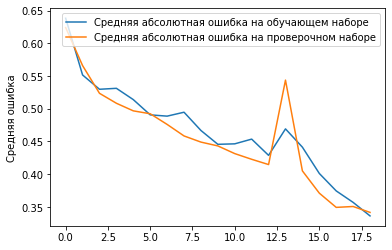

In [ ]:
callbaсk = EarlyStopping(monitor='val_mae', patience=5)

model = Sequential()

model.add(LSTM(64, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))
model.add(LSTM(64, return_sequences="True")) # <None, 3,32>
model.add(Conv1D(64, 3, activation="linear")) #(None,3,64)
#model.add(Conv1D(64, 1, activation="linear"))
model.add(Flatten())                          # (None, 3*64)
model.add(Dense(3, activation="linear"))      # (None,3)

model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="adam", metrics=['mae'])

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[callbaсk, tensorboard_callback])


plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
%tensorboard --logdir logs2

In [ ]:
hist_val = history.history['val_mae']
hist_train = history.history['mae']

Epoch 1/20
30/30 [==============================] - 1s 49ms/step - loss: 0.1940 - mae: 0.3377 - val_loss: 0.2343 - val_mae: 0.3497
Epoch 2/20
30/30 [==============================] - 1s 42ms/step - loss: 0.1761 - mae: 0.3219 - val_loss: 0.2102 - val_mae: 0.3279
Epoch 3/20
30/30 [==============================] - 1s 41ms/step - loss: 0.1884 - mae: 0.3339 - val_loss: 0.2525 - val_mae: 0.3612
Epoch 4/20
30/30 [==============================] - 1s 41ms/step - loss: 0.1654 - mae: 0.3136 - val_loss: 0.2032 - val_mae: 0.3257
Epoch 5/20
30/30 [==============================] - 1s 42ms/step - loss: 0.1532 - mae: 0.3010 - val_loss: 0.2021 - val_mae: 0.3262
Epoch 6/20
30/30 [==============================] - 1s 42ms/step - loss: 0.1484 - mae: 0.2963 - val_loss: 0.2275 - val_mae: 0.3383
Epoch 7/20
30/30 [==============================] - 1s 43ms/step - loss: 0.1461 - mae: 0.2937 - val_loss: 0.2086 - val_mae: 0.3230
Epoch 8/20
30/30 [==============================] - 1s 45ms/step - loss: 0.1496 - m

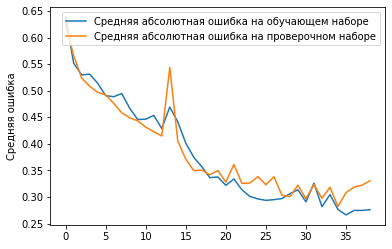

In [ ]:
history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[callbaсk, tensorboard_callback])

hist_val.extend(history.history['val_mae'][:])
hist_train.extend(history.history['mae'][:])

plt.plot(hist_train[1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(hist_val[1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
%tensorboard --logdir logs2

Проверяем результаты:

- строим предсказание
- рисуем прогноз для тестовой части 
- рисуем прогноз по тренировочной части

In [ ]:
pred = model.predict(dataset_train).flatten()
predVal = model.predict(dataset_val).flatten()

Валидация:

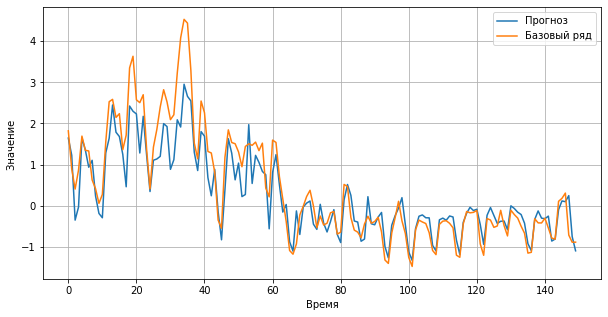

In [ ]:
start = 600
step = 150
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(predVal[start:start+step], 
         label='Прогноз')
plt.plot(yVal.flatten()[start:start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

Тренировочные даннные:

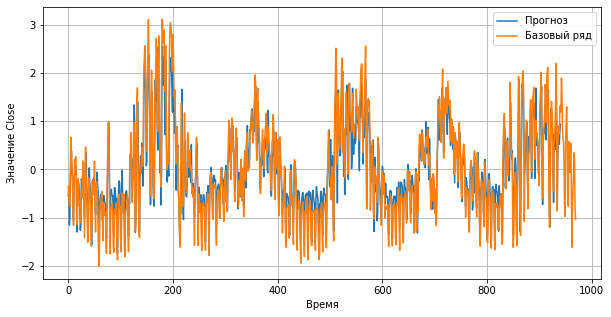

In [ ]:
start = 0


plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(pred[start:train_split], 
         label='Прогноз')
plt.plot(yTrain.flatten()[start:train_split], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение Close')
plt.legend()
plt.show()

Лекция 1:51

Проверяем качество модели:
- оценим по лаговой корреляции рядов a, b;
- если наибольшая корреляция с лагом 0, то отлично;
- есди максимум корреляциии на лаге , равном глубине прогноза, то тривиальное предсказание (завтра, как сегодня).

In [ ]:
def correlate(a, b):
  ma = a.mean()
  mb = b.mean()
  mab = (a*b).mean()
  sa = a.std()
  sb = b.std()
  
  val = 0
  if ((sa>0) & (sb>0)):
    val = (mab-ma*mb)/(sa*sb)
  return val

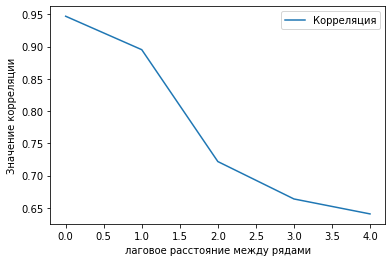

In [ ]:
corr = []
start = 600 # начальная точка для проверки корреляций рядов
step = 150 # число точек для проверки корреляций рядов
h=0
yLen = yVal.shape[0]
yValF = yVal[start:start+step].flatten() # ряд истиных значений
yPredVal = predVal[start:start+step] # ряд предсказаний 
# смотрим лаговые корреляции yValF[:-i], yPredVal[i:] для лагов от 0 до 5
for i in range(5):
  corr.append(correlate(yValF[:-1-i], yPredVal[i:-1]))
  
plt.plot(corr, 
         label='Корреляция')
plt.xlabel('лаговое расстояние между рядами')
plt.ylabel('Значение корреляции')
plt.legend()
plt.show()

Хорошая картинки лаговой корреляции ряда yValF[:-i], yPredVal[i:]

In [ ]:
corr

[0.9470202096586472,
 0.895162323851844,
 0.7217414374424613,
 0.6637630383428159,
 0.640573998003385]

Можно добавить обучения на другом размере сети

Epoch 1/100
30/30 [==============================] - 3s 38ms/step - loss: 0.8862 - mae: 0.7493 - val_loss: 0.5730 - val_mae: 0.5499
Epoch 2/100
30/30 [==============================] - 1s 20ms/step - loss: 0.4783 - mae: 0.5282 - val_loss: 0.4676 - val_mae: 0.5043
Epoch 3/100
30/30 [==============================] - 1s 20ms/step - loss: 0.4125 - mae: 0.4904 - val_loss: 0.4250 - val_mae: 0.4812
Epoch 4/100
30/30 [==============================] - 1s 20ms/step - loss: 0.3809 - mae: 0.4703 - val_loss: 0.4001 - val_mae: 0.4656
Epoch 5/100
30/30 [==============================] - 1s 20ms/step - loss: 0.3578 - mae: 0.4545 - val_loss: 0.3844 - val_mae: 0.4547
Epoch 6/100
30/30 [==============================] - 1s 20ms/step - loss: 0.3402 - mae: 0.4426 - val_loss: 0.3747 - val_mae: 0.4481
Epoch 7/100
30/30 [==============================] - 1s 20ms/step - loss: 0.3294 - mae: 0.4358 - val_loss: 0.3739 - val_mae: 0.4480
Epoch 8/100
30/30 [==============================] - 1s 19ms/step - loss: 0.

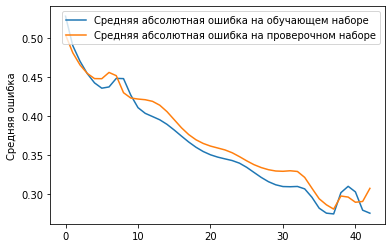

In [ ]:
callbaсk = EarlyStopping(monitor='val_mae', patience=5)

model = Sequential()

model.add(LSTM(32, input_shape = (inputs.shape[1], inputs.shape[2]), return_sequences="True"))

model.add(Flatten())                          # (None, 3*64)
model.add(Dense(3, activation="linear"))      # (None,3)

model.add(Dense(1, activation="linear"))

model.compile(loss="mse", optimizer="adam", metrics=['mae'])

history = model.fit(
    dataset_train,
    epochs=100,
    validation_data=dataset_val,
    callbacks=[callbaсk, tensorboard_callback])


plt.plot(history.history['mae'][1:], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'][1:], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [ ]:
pred = model.predict(dataset_train).flatten()
predVal = model.predict(dataset_val).flatten()

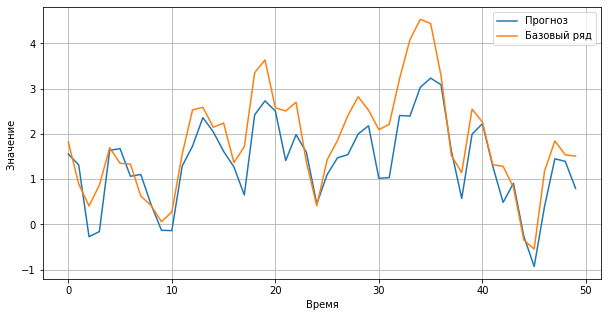

In [ ]:
start = 600
step = 50
plt.figure(figsize=(10,5))
plt.grid('on')
plt.plot(predVal[start:start+step], 
         label='Прогноз')
plt.plot(yVal.flatten()[start:start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

Проверим лаговые корреляции:

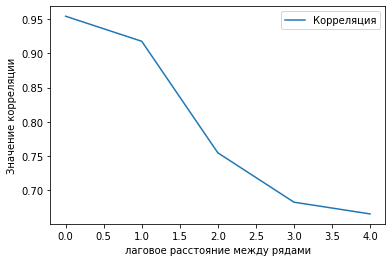

In [ ]:
corr = []
start = 600 # начальная точка для проверки корреляций рядов
step = 150 # число точек для проверки корреляций рядов
h=0
yLen = yVal.shape[0]
yValF = yVal[start:start+step].flatten() # ряд истиных значений
yPredVal = predVal[start:start+step] # ряд предсказаний 
# смотрим лаговые корреляции yValF[:-i], yPredVal[i:] для лагов от 0 до 5
for i in range(5):
  corr.append(correlate(yValF[:-1-i], yPredVal[i:-1]))
  
plt.plot(corr, 
         label='Корреляция')
plt.xlabel('лаговое расстояние между рядами')
plt.ylabel('Значение корреляции')
plt.legend()
plt.show()

In [ ]:
corr

[0.9543517412756335,
 0.9176990533840983,
 0.7545051114767154,
 0.6822939011882,
 0.6651057516135714]

####**2.** Попробуйте изменить параметры нейронной сети, генерирующей текст таким образом, чтобы добиться генерации как можно более осмысленного текста. Пришлите лучший текст из получившихся и опишите предпринятые для его получения действия. Можно использовать текст другого произведения

Выделил в отдельный блокнот - [hw_les_5.2](https://github.com/djo1006/Introduction_Neural_Networks/blob/main/hw_les_5_2.ipynb)